# Goal
- solve 
$$
\argmin_{\lambda} ||\Gamma - \Gamma_0||_F^2 \\
\text{s.t.} \\
\Gamma = \lambda \Gamma_0 + \mu_y\mu_x^T - \lambda \mu_{y_0}\mu_x^T \\
\mathbb{1}^T\Gamma = \mu_x^T \\
\Gamma \mathbb{1}= \mu_y \\
\Gamma_{ij} \geq 0 \\
\sum_{ij} \Gamma_{ij} = 1 \\
\text{where} \\
\mathbb{1}^T\Gamma_0 = \mu_x^T \\
\Gamma_0 \mathbb{1} = \mu_{y_0} \\
$$

# imports

In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

# cvx solvers

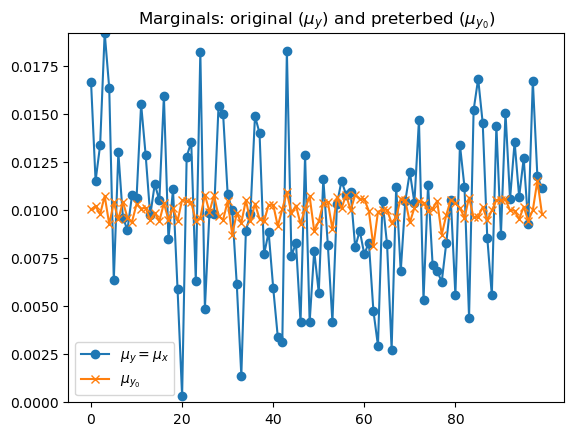

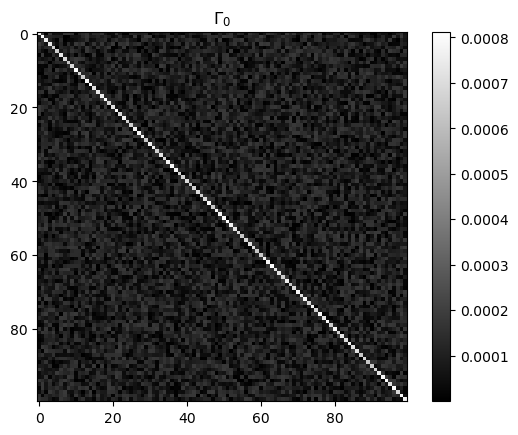

In [2]:
# Define epsilon
n = 100

# Define constants
Gamma_0 = (1 / n) * np.eye(n)
# mu_x = (1/n) * np.ones(n)
# mu_y0 = mu_x.copy()

# mu_x = uniform_weights_i.numpy()
# mu_y0 = uniform_weights_j0.numpy()
# mu_y = uniform_weights_j.numpy()
# mu_y /= mu_y.sum()
# mu_y = np.ones(n) / n
# Gamma_0 = log0["T"]

# n = len(Gamma_0)


# Define a row permutation (e.g., swap row 0 and row 2)
def swap_rows(A, perm=None):
    if perm is None:
        perm = np.arange(n)
        np.random.seed(0)
        np.random.shuffle(perm)
    Pi = np.eye(n)[perm]  # Create permutation matrix

    # Apply permutation
    return Pi @ A


# perm = np.arange(n)
# perm[6] = 8
# perm[8] = 6
# perm[11] = 17
# perm[17] = 11
# Gamma_0 = swap_rows(Gamma_0, perm)

noise_eps = 0.3 / n
joint_dist_noise = noise_eps * np.abs(np.random.rand(n, n))
Gamma_0 += joint_dist_noise
Gamma_0 /= Gamma_0.sum()

mu_x = Gamma_0.sum(axis=0)
mu_y0 = Gamma_0.sum(axis=1)
# mu_y = mu_y0 # log["T"].sum(axis=1)

np.random.seed(0)
eps = 4e-3  # 0.1 / n  # Define epsilon as a parameter to allow flexibility
noise = np.random.normal(0, eps, n)
mu_y = np.abs(mu_y0 + noise)
mu_y /= mu_y.sum()


# plot muy and muy0
plt.figure()
plt.plot(mu_y, label=r"$\mu_y = \mu_x$", marker="o")
plt.plot(mu_y0, label=r"$\mu_{y_0}$", marker="x")
plt.legend()
plt.ylim([0, max(mu_y0.max(), mu_y.max())])
plt.xticks(range(0, n, n // 5))
plt.title(r"Marginals: original ($\mu_y$) and preterbed ($\mu_{y_0}$)")
plt.show()

plt.figure()
plt.imshow(Gamma_0, cmap="gray")
plt.title(r"$\Gamma_0$")
plt.colorbar()
plt.show()

In [ ]:
def solve_for_close_joint_distribution(
    Gamma_0, mu_x, mu_y, mu_y0, constraint_eps, use_equality_constraints=False, **kwargs
):
    # Define variable
    lambda_var = cp.Variable(nonneg=True)
    Gamma = (
        lambda_var * Gamma_0 + np.outer(mu_y, mu_x) - lambda_var * np.outer(mu_y0, mu_x)
    )

    # Define constraints
    equality_constraints = [
        # cp.sum(Gamma) == 1,  # Sum constraint
        cp.sum(Gamma, axis=0) == mu_x,  # Column sum constraint
        # cp.sum(Gamma, axis=1) == mu_y,  # Row sum constraint
        # Gamma >= 0,  # Non-negativity constraint
    ]
    inequality_constraints = [
        -constraint_eps + cp.sum(Gamma) <= 1,
        # -constraint_eps + cp.sum(Gamma, axis=0) <= mu_x,
        -constraint_eps + cp.sum(Gamma, axis=1) <= mu_y,
        +constraint_eps + cp.sum(Gamma) >= 1,
        # +constraint_eps + cp.sum(Gamma, axis=0) >= mu_x,
        +constraint_eps + cp.sum(Gamma, axis=1) >= mu_y,
        Gamma >= 0,  # Non-negativity constraint
    ]
    constraints = inequality_constraints
    if use_equality_constraints:
        constraints += equality_constraints

    # Define objective
    objective = cp.Minimize(cp.norm(Gamma - Gamma_0, "fro") ** 2)

    # Solve problem
    problem = cp.Problem(objective, constraints)

    # Assign a value to epsilon and solve
    # eps.value = 0.01  # Example value
    problem.solve(**kwargs)

    # Print results
    if problem.status == "infeasible":
        assert lambda_var.value is None, problem.status
        print("Problem is infeasible: optimal lambda 0 by definition")
        lambda_opt = 0
    else:
        print("Problem status:", problem.status)
        assert lambda_var.value is not None, problem.status
        lambda_opt = lambda_var.value
    Gamma = (
        lambda_opt * Gamma_0 + np.outer(mu_y, mu_x) - lambda_opt * np.outer(mu_y0, mu_x)
    )
    return Gamma, lambda_opt, problem

In [4]:
Gamma, lambda_opt, problem = solve_for_close_joint_distribution(
    Gamma_0,
    mu_x,
    mu_y,
    mu_y0,
    constraint_eps=1e-5,
    solver="SCS",
    eps=1e-5,
    # 1e-6 for n=500
    # 1e-5 for n=100
)
# Print results
print("Optimal lambda:", lambda_opt)

Problem status: optimal
Optimal lambda: 1.0372083409790623e-08


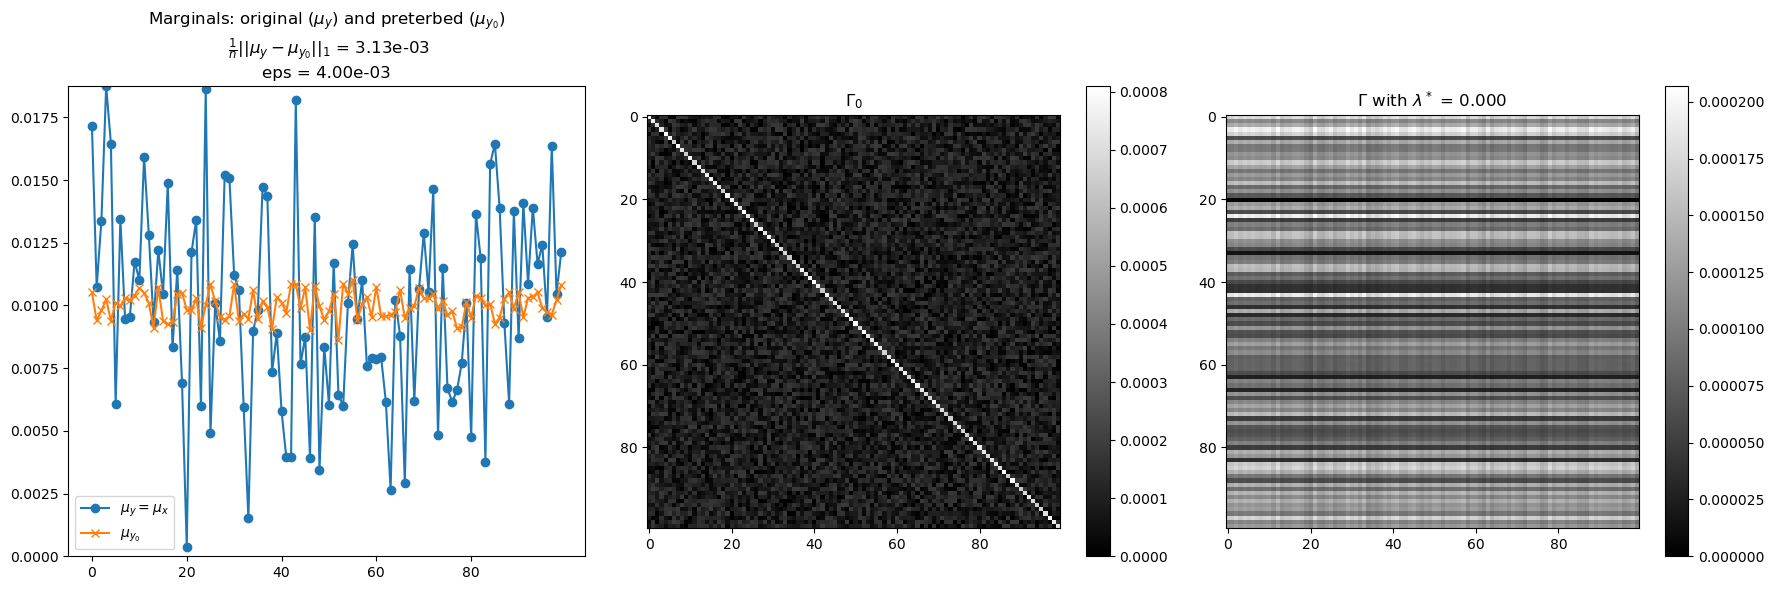

In [5]:
annotate_red_numbers = False
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# plot muy and muy0

idx = 0
axes[idx].plot(mu_y, label=r"$\mu_y = \mu_x$", marker="o")
axes[idx].plot(mu_y0, label=r"$\mu_{y_0}$", marker="x")
axes[idx].legend()
axes[idx].set_ylim([0, max(mu_y0.max(), mu_y.max())])
axes[idx].set_xticks(range(0, n, n // 5))
axes[idx].set_title(
    r"Marginals: original ($\mu_y$) and preterbed ($\mu_{y_0}$)"
    + "\n"
    + r" $\frac{1}{n}||\mu_y - \mu_{y_0}||_1$ = "
    + "{:1.2e}\n".format(np.abs(mu_y - mu_y0).mean())
    + "eps = {:1.2e}".format(eps)
)


# Plot Gamma_0
idx += 1
im1 = axes[idx].imshow(Gamma_0, cmap="gray", vmin=0, vmax=Gamma_0.max())
fig.colorbar(im1, ax=axes[idx])
axes[idx].set_title(r"$\Gamma_0$")
# Annotate Gamma with numbers
if annotate_red_numbers:
    # Annotate Gamma_0 with numbers
    for i in range(Gamma_0.shape[0]):
        for j in range(Gamma_0.shape[1]):
            axes[idx].text(
                j, i, f"{Gamma_0[i, j]:.2e}", ha="center", va="center", color="red"
            )

# Plot Gamma
idx += 1
im0 = axes[idx].imshow(Gamma, cmap="gray", vmin=0, vmax=Gamma.max())
fig.colorbar(im0, ax=axes[idx])
axes[idx].set_title(r"$\Gamma$ with $\lambda^*$ = {:1.3f}".format(lambda_opt))

# Annotate Gamma with numbers
if annotate_red_numbers:
    for i in range(Gamma.shape[0]):
        for j in range(Gamma.shape[1]):
            axes[idx].text(
                j, i, f"{Gamma[i, j]:.2e}", ha="center", va="center", color="red"
            )

plt.tight_layout()
plt.show()

In [7]:
np.random.seed(0)

n_nosie_levels = 10
max_noise_level = 10
min_noise_level = 0.1
eps_s = (
    np.exp(
        np.linspace(np.log(min_noise_level), np.log(max_noise_level), n_nosie_levels)
    )
    / n
)
norms = np.zeros(len(eps_s))
lambda_opts = np.zeros(len(eps_s))
for idx, eps in enumerate(eps_s):
    # eps = eps_ / n  # Define epsilon as a parameter to allow flexibility
    noise = np.random.normal(0, eps, n)
    mu_y = np.abs(mu_y0 + noise)
    mu_y /= mu_y.sum()
    norms[idx] = np.abs(mu_y - mu_y0).mean()  # L1

    Gamma, lambda_opt, problem = solve_for_close_joint_distribution(
        Gamma_0, mu_x, mu_y, mu_y0, constraint_eps=1e-5, solver="SCS", eps=1e-5
    )
    lambda_opts[idx] = lambda_opt

Problem status: optimal
Problem status: optimal
Problem status: optimal
Problem status: optimal
Problem status: optimal
Problem status: optimal
Problem status: optimal
Problem status: optimal
Problem status: optimal
Problem status: optimal


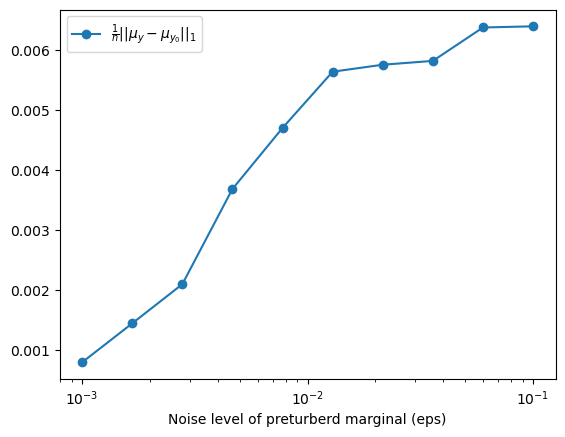

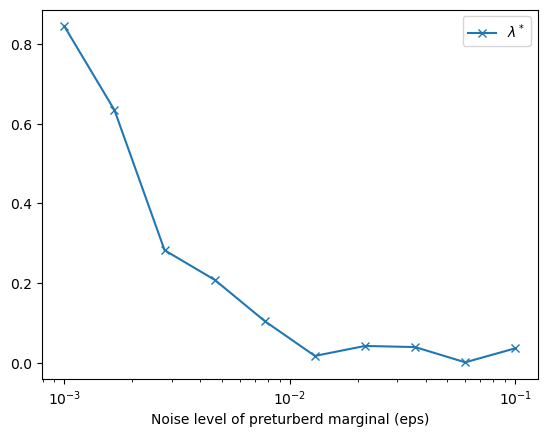

In [41]:
plt.figure()
plt.plot(eps_s, norms, label=r"$\frac{1}{n}||\mu_y - \mu_{y_0}||_1$", marker="o")
plt.xlabel(r"Noise level of preturberd marginal (eps)")
plt.legend()
plt.xscale("log")

plt.show()

plt.figure()
plt.plot(eps_s, lambda_opts, label=r"$\lambda^*$", marker="x")

plt.xlabel(r"Noise level of preturberd marginal (eps)")
plt.legend()
plt.xscale("log")
plt.show()

# local GW

In [69]:
import torch
import ot

# Set random seed for reproducibility
torch.manual_seed(42)

# Number of points
num_points = n = 100

# Sample random points in 3D
dim = 3
sparse_coordinates_i = torch.rand((num_points, dim))
# sparse_coordinates_j = torch.rand((num_points, dim))
point_eps = 0.0275
noise_coords = torch.randn_like(sparse_coordinates_i)
noise_coords[: n // 2] = 0
sparse_coordinates_j = sparse_coordinates_i + point_eps * noise_coords

# Compute pairwise distances
pairwise_distances_i = torch.cdist(sparse_coordinates_i, sparse_coordinates_i)
pairwise_distances_j = torch.cdist(sparse_coordinates_j, sparse_coordinates_j)

# Define uniform weights
uniform_weights_i = torch.full((num_points,), 1.0 / num_points)
eps = 0.01 / n
uniform_weights_j0 = uniform_weights_i + eps * torch.randn_like(uniform_weights_i)
uniform_weights_j0 = torch.abs(uniform_weights_j0)
uniform_weights_j0 /= uniform_weights_j0.sum()


# Compute Gromov-Wasserstein distance
_, log0 = ot.gromov.gromov_wasserstein2(
    pairwise_distances_i.numpy(),  # Cost matrix for source
    pairwise_distances_j.numpy(),  # Cost matrix for target
    uniform_weights_i.numpy(),  # Uniform distribution for source
    uniform_weights_j0.numpy(),  # Uniform distribution for target
    "square_loss",
    log=True,
    verbose=True,
)

# Print result
print("Gromov-Wasserstein distance:", log0["gw_dist"])

It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.336255e-01|0.000000e+00|0.000000e+00
    1|8.959332e-02|4.914670e-01|4.403216e-02
    2|4.227154e-02|1.119471e+00|4.732178e-02
    3|1.980800e-02|1.134064e+00|2.246354e-02
    4|1.881099e-02|5.300155e-02|9.970117e-04
    5|1.880729e-02|1.966029e-04|3.697568e-06
    6|1.880729e-02|0.000000e+00|0.000000e+00
Gromov-Wasserstein distance: 0.018807293455523677


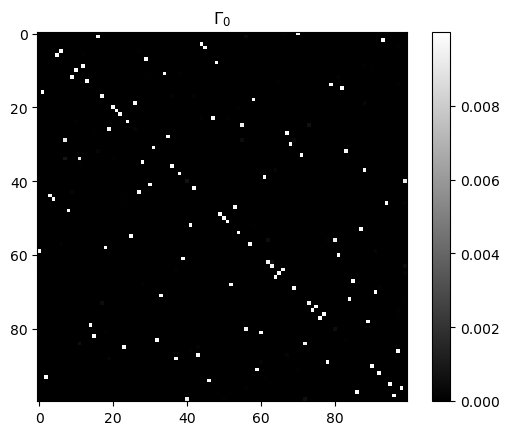

In [70]:
plt.figure()
plt.imshow(log0["T"], cmap="gray")
plt.title(r"$\Gamma_0$")
plt.colorbar()

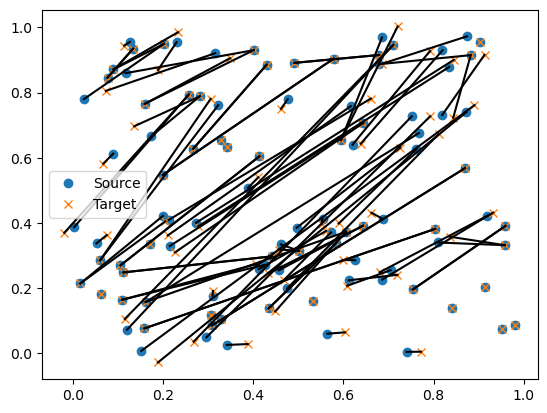

In [71]:
sparse_coordinates_i_np = sparse_coordinates_i.numpy()
sparse_coordinates_j_np = sparse_coordinates_j.numpy()


plt.plot(
    sparse_coordinates_i_np[:, 0], sparse_coordinates_i_np[:, 1], "o", label="Source"
)
plt.plot(
    sparse_coordinates_j_np[:, 0], sparse_coordinates_j_np[:, 1], "x", label="Target"
)
plt.legend()

# connect with lines from joint distribution transport plan
for i in range(num_points):
    for j in range(num_points):
        if log0["T"][i, j] > 0.5 / n:
            plt.plot(
                [sparse_coordinates_i_np[i, 0], sparse_coordinates_j_np[j, 0]],
                [sparse_coordinates_i_np[i, 1], sparse_coordinates_j_np[j, 1]],
                "k",
                alpha=1,
            )

In [72]:
# gw = 0
# for i in range(num_points):
#     for j in range(num_points):
#         for k in range(num_points):
#             for l in range(num_points):
#                 gw += (pairwise_distances_i[i,j] - pairwise_distances_j[k,l])**2 * log['T'][i,k] * log['T'][j,l]


In [80]:
torch.manual_seed(0)
eps = 0.005 / n
uniform_weights_j = uniform_weights_j0 + eps * torch.randn_like(uniform_weights_j0)
uniform_weights_j = torch.abs(uniform_weights_j)
uniform_weights_j /= uniform_weights_j.sum()

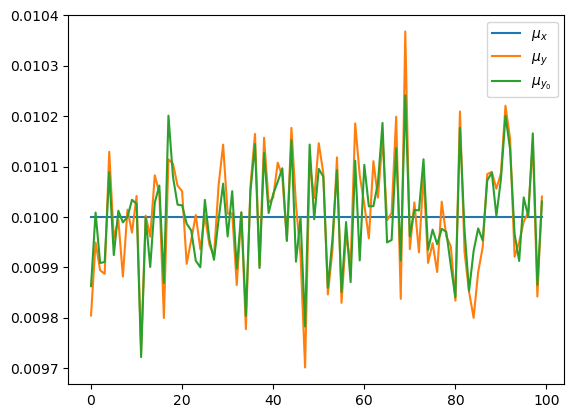

In [81]:
mu_x = uniform_weights_i.numpy()
mu_y0 = uniform_weights_j0.numpy()
mu_y = uniform_weights_j.numpy()
Gamma_0 = log0["T"]
# mu_x = Gamma_0.sum(axis=0)
# mu_x /= mu_x.sum()
# mu_y0 = Gamma_0.sum(axis=1)
# mu_y0 /= mu_y0.sum()
# Gamma = log["T"]
# mu_y = Gamma.sum(axis=1)
mu_y /= mu_y.sum()
# mu_x = mu_y = mu_y0 = np.ones(n) / n

plt.figure()
plt.plot(mu_x, label=r"$\mu_x$")
plt.plot(mu_y, label=r"$\mu_y$")
plt.plot(mu_y0, label=r"$\mu_{y_0}$")
plt.legend()
# plt.ylim([0, max(mu_y0.max(), mu_y.max(), mu_x.max())])

In [83]:
e = 1e-4
Gamma_closefro, lambda_opt, problem = solve_for_close_joint_distribution(
    Gamma_0,
    mu_x,
    mu_y,
    mu_y0,
    constraint_eps=e,
    solver="SCS",
    eps=e,
    verbose=True,
    eps_infeas=e,
    max_iters=2000,
)
(
    lambda_opt,
    np.linalg.norm(Gamma_closefro.sum(axis=0) - uniform_weights_i.numpy()),
    np.linalg.norm(Gamma_closefro.sum(axis=1) - uniform_weights_j.numpy()),
)

                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Mar 05 04:53:21 AM: Your problem has 1 variables, 10202 constraints, and 0 parameters.
(CVXPY) Mar 05 04:53:21 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 05 04:53:21 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 05 04:53:21 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Mar 05 04:53:21 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 05 04:53:21 AM: Compiling problem (target solver=SCS).
(C

(0.4876159841692609, 0.00047784336, 0.00047784325)

In [85]:
e = 1e-3
dtype = np.float64
Gamma_closefro, lambda_opt, problem = solve_for_close_joint_distribution(
    Gamma_0,
    mu_x,
    mu_y,
    mu_y0,
    constraint_eps=e,
    solver="CVXOPT",
    abstol=e,
    reltol=e,
    feastol=e,
    verbose=True,
    max_iters=20,
)
(
    lambda_opt,
    np.linalg.norm(Gamma_closefro.sum(axis=0) - uniform_weights_i.numpy()),
    np.linalg.norm(Gamma_closefro.sum(axis=1) - uniform_weights_j.numpy()),
)

                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Mar 05 04:54:05 AM: Your problem has 1 variables, 10202 constraints, and 0 parameters.
(CVXPY) Mar 05 04:54:05 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 05 04:54:05 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 05 04:54:05 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Mar 05 04:54:05 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 05 04:54:05 AM: Compiling problem (target solver=CVXOPT).

(0.9638539957693094, 0.0009445392, 0.0009445413)

In [86]:
np.testing.assert_allclose(Gamma_closefro.sum(axis=1), uniform_weights_j, atol=1e-2)

In [87]:
np.testing.assert_allclose(Gamma_closefro.sum(axis=0), uniform_weights_i, atol=1e-2)

In [88]:
np.linalg.norm(Gamma_closefro.sum(axis=0) - uniform_weights_i.numpy())

0.0009445392

In [89]:
# Compute Gromov-Wasserstein distance
_, log_local = ot.gromov.gromov_wasserstein2(
    pairwise_distances_j.numpy(),  # Cost matrix for source
    pairwise_distances_i.numpy(),  # Cost matrix for target
    uniform_weights_j.numpy(),  # Uniform distribution for source
    uniform_weights_i.numpy(),  # Uniform distribution for target
    "square_loss",
    log=True,
    verbose=True,
)
Gamma_gwsolved_local = log_local["T"]
# Print result
print("Gromov-Wasserstein distance:", log_local["gw_dist"])

It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.336362e-01|0.000000e+00|0.000000e+00
    1|9.267392e-02|4.420039e-01|4.096224e-02
    2|5.110733e-02|8.133197e-01|4.156660e-02
    3|2.801382e-02|8.243611e-01|2.309351e-02
    4|9.000162e-04|3.012591e+01|2.711381e-02
    5|8.871534e-04|1.449893e-02|1.286277e-05
    6|8.871473e-04|6.890030e-06|6.112471e-09
    7|8.871473e-04|0.000000e+00|0.000000e+00
Gromov-Wasserstein distance: 0.0008871472802112201


In [90]:
# Compute Gromov-Wasserstein distance from close joint distribution
_, log_init = ot.gromov.gromov_wasserstein2(
    pairwise_distances_j.numpy(),  # Cost matrix for source
    pairwise_distances_i.numpy(),  # Cost matrix for target
    uniform_weights_j.numpy(),  # Uniform distribution for source
    uniform_weights_i.numpy(),  # Uniform distribution for target
    "square_loss",
    log=True,
    verbose=True,
    G0=Gamma_closefro,
    marginal_tol=1e-2,
)
Gamma_gwsolved_local_init = log_init["T"]
# Print result
print("Gromov-Wasserstein distance:", log_init["gw_dist"])

It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.636968e-02|0.000000e+00|0.000000e+00
    1|1.889143e-02|3.958545e-01|7.478256e-03
    2|1.889013e-02|6.835828e-05|1.291297e-06
    3|1.889013e-02|3.711587e-09|7.011237e-11
Gromov-Wasserstein distance: 0.018890134436081216


In [91]:
len(log_init["loss"])

4

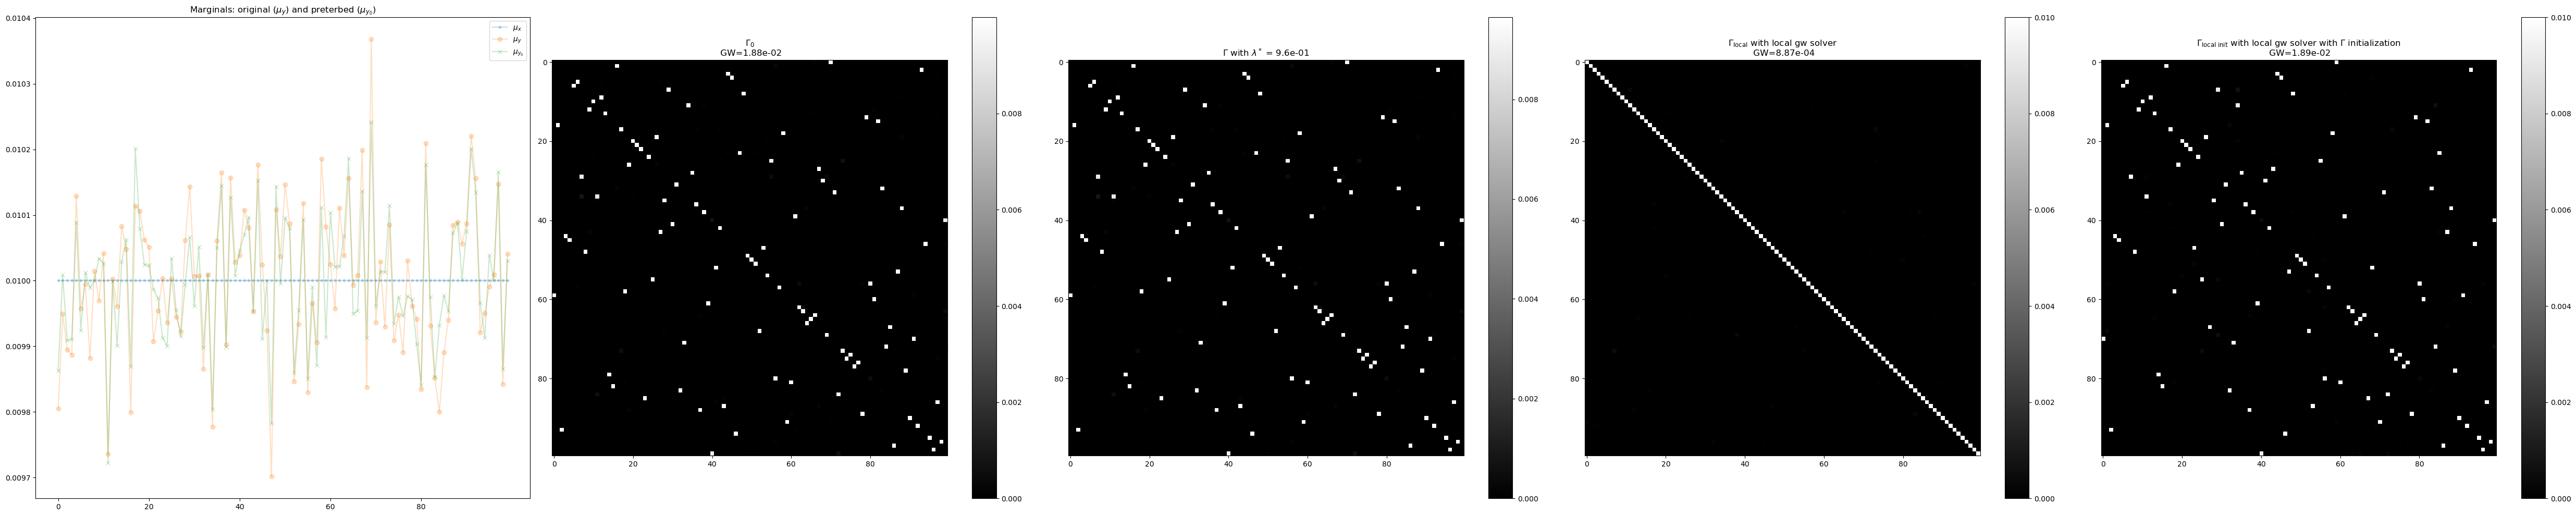

In [92]:
annotate_red_numbers = False
fig, axes = plt.subplots(1, 5, figsize=(50, 10))

# plot muy and muy0

idx = 0
alpha = 0.25
axes[idx].plot(mu_x, label=r"$\mu_x$", marker=".", alpha=alpha)
axes[idx].plot(mu_y, label=r"$\mu_y$", marker="o", alpha=alpha)
axes[idx].plot(mu_y0, label=r"$\mu_{y_0}$", marker="x", alpha=alpha)
axes[idx].legend()
# axes[idx].set_ylim([0, max(mu_x.max(), mu_y0.max(), mu_y.max())])
axes[idx].set_xticks(range(0, n, n // 5))
axes[idx].set_title(r"Marginals: original ($\mu_y$) and preterbed ($\mu_{y_0}$)")


# Plot Gamma_0
idx += 1
im1 = axes[idx].imshow(Gamma_0, cmap="gray", vmin=0, vmax=Gamma_0.max())
fig.colorbar(im1, ax=axes[idx])
axes[idx].set_title(r"$\Gamma_0$" + "\n GW={:1.2e}".format(log0["gw_dist"]))
# Annotate Gamma with numbers
if annotate_red_numbers:
    # Annotate Gamma_0 with numbers
    for i in range(Gamma_0.shape[0]):
        for j in range(Gamma_0.shape[1]):
            axes[idx].text(
                j, i, f"{Gamma_0[i, j]:.2e}", ha="center", va="center", color="red"
            )

# Plot Gamma
idx += 1
im0 = axes[idx].imshow(Gamma_closefro, cmap="gray", vmin=0, vmax=Gamma_closefro.max())
fig.colorbar(im0, ax=axes[idx])
axes[idx].set_title(r"$\Gamma$ with $\lambda^*$ = {:1.1e}".format(lambda_opt))

# Annotate Gamma with numbers
if annotate_red_numbers:
    for i in range(Gamma_closefro.shape[0]):
        for j in range(Gamma_closefro.shape[1]):
            axes[idx].text(
                j,
                i,
                f"{Gamma_closefro[i, j]:.2e}",
                ha="center",
                va="center",
                color="red",
            )

# Plot Gamma local
idx += 1
im0 = axes[idx].imshow(
    Gamma_gwsolved_local, cmap="gray"
)  # vmin=0, vmax=Gamma_gwsolved_local.max())
fig.colorbar(im0, ax=axes[idx])
axes[idx].set_title(
    r"$\Gamma_{\text{local}}$ with local gw solver"
    + "\n GW={:1.2e}".format(log_local["gw_dist"])
)

# Annotate Gamma with numbers
if annotate_red_numbers:
    for i in range(Gamma_gwsolved_local.shape[0]):
        for j in range(Gamma_gwsolved_local.shape[1]):
            axes[idx].text(
                j,
                i,
                f"{Gamma_gwsolved_local[i, j]:.2e}",
                ha="center",
                va="center",
                color="red",
            )

# Plot delta
idx += 1
im0 = axes[idx].imshow(
    Gamma_gwsolved_local_init, cmap="gray"
)  # vmin=0, vmax=Gamma_gwsolved_local.max())
fig.colorbar(im0, ax=axes[idx])
axes[idx].set_title(
    r"$\Gamma_{\text{local init}}$ with local gw solver with $\Gamma$ initialization"
    + "\n GW={:1.2e}".format(log_init["gw_dist"])
)

# Annotate Gamma with numbers
if annotate_red_numbers:
    for i in range(Gamma_gwsolved_local_init.shape[0]):
        for j in range(Gamma_gwsolved_local_init.shape[1]):
            axes[idx].text(
                j,
                i,
                f"{Gamma_gwsolved_local_init[i, j]:.2e}",
                ha="center",
                va="center",
                color="red",
            )

# # Plot delta
# idx += 1
# im0 = axes[idx].imshow(
#     Gamma_closefro - Gamma_gwsolved_local, cmap="gray"
# )  # vmin=0, vmax=Gamma_gwsolved_local.max())
# fig.colorbar(im0, ax=axes[idx])
# axes[idx].set_title(r"$\Delta$ $\Gamma - \Gamma_{\text{local}}$")

# # Annotate Gamma with numbers
# if annotate_red_numbers:
#     for i in range(Gamma_gwsolved_local.shape[0]):
#         for j in range(Gamma_gwsolved_local.shape[1]):
#             axes[idx].text(
#                 j,
#                 i,
#                 f"{Gamma_closefro - Gamma_gwsolved_local[i, j]:.2e}",
#                 ha="center",
#                 va="center",
#                 color="red",
#             )

plt.tight_layout()
plt.show()